# 🤖 CartPole-v1 RL Training: REINFORCE & Actor-Critic Methods
## Comprehensive Implementation with Optimized Hyperparameters
This notebook implements and compares 4 policy gradient algorithms with state-of-the-art techniques: orthogonal initialization, entropy regularization, and GAE for robust convergence.

---

## 📦 Cell 1: Installation & Dependencies
Install required packages for RL training: gym, torch, matplotlib, numpy

In [1]:
!pip install gym[atari] --quiet
!pip install torch torchvision --quiet
!pip install matplotlib numpy --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 11.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/

## 📚 Cell 2: Import Libraries
Import core libraries for reinforcement learning, neural networks, and visualization

In [2]:
import gym                 
import numpy as np         
import torch              
import torch.nn as nn      
import torch.nn.functional as F  
import torch.optim as optim      
import random             
import matplotlib.pyplot as plt


## ⚙️ Cell 2: Hyperparameter Configuration
Define environment, algorithm-specific hyperparameters, network architecture, and training settings for optimal convergence

In [3]:
# Choix de l'environnement
ENV_NAME = "CartPole-v1"  # Peut remplacer par LunarLander-v2 ou PongNoFrameskip-v4

# ===== OPTIMIZED HYPERPARAMETERS FOR CARTPOLE-V1 =====
# Global hyperparameters
GAMMA = 0.99              # Discount factor - optimal for CartPole
EPISODES = 2000            # Increased episodes for convergence and good performance
SEED = 42                 # Better reproducibility

# Algorithm-specific hyperparameters (fine-tuned)
LR_REINFORCE = 1e-2       # Higher LR for REINFORCE (policy-only)
LR_A2C_SEP = 5e-3         # Separate actor/critic learning rates
LR_A2C_SHARED = 5e-3      # Shared network learning rate
LR_GAE = 5e-3             # GAE learning rate

# Entropy coefficient for exploration
ENTROPY_COEF_REINFORCE = 0.01
ENTROPY_COEF_A2C = 0.005
ENTROPY_COEF_GAE = 0.005

# Value coefficient (for actor-critic methods)
VALUE_COEF = 0.5

# GAE lambda - higher lambda = higher variance, lower bias
GAE_LAMBDA = 0.95

# Gradient clipping
MAX_GRAD_NORM = 0.5

# Network architecture sizes
HIDDEN_SIZES = [128, 128]  # Larger networks for better approximation

# Fixer les seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Créer l'environnement
env = gym.make(ENV_NAME)
obs_dim = env.observation_space.shape[0]   # Taille de l'état
act_dim = env.action_space.n               # Nombre d'actions possibles

# Choix du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✓ Using device: {device}")
print(f"✓ Environment: {ENV_NAME}")
print(f"✓ Observation dimension: {obs_dim}")
print(f"✓ Action dimension: {act_dim}")
print(f"✓ Max episodes: {EPISODES}")
print(f"✓ Hyperparameters optimized for CartPole-v1")

✓ Using device: cuda
✓ Environment: CartPole-v1
✓ Observation dimension: 4
✓ Action dimension: 2
✓ Max episodes: 2000
✓ Hyperparameters optimized for CartPole-v1


## 🔢 Cell 3: Utility Function - Discounted Cumulative Sum
Calculate discounted returns (G_t) from episode rewards for advantage computation

In [4]:
def discount_cumsum(rewards, gamma):
    """
    Calcule les retours cumulés à partir de la fin de l'épisode.
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    """
    n = len(rewards)
    discounted = np.zeros(n)
    r = 0
    for i in reversed(range(n)):
        r = rewards[i] + gamma * r
        discounted[i] = r
    return discounted


## 🎯 Cell 4: REINFORCE Policy Network
Implement REINFORCE policy with orthogonal initialization, entropy regularization, and baseline support

In [5]:
class REINFORCEPolicy(nn.Module):
    """
    REINFORCE with entropy regularization and baseline normalization
    """
    def __init__(self, input_dim, output_dim, hidden_sizes=HIDDEN_SIZES):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.out = nn.Linear(hidden_sizes[1], output_dim)
        
        # Initialize weights properly
        for layer in [self.fc1, self.fc2, self.out]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.out(x)
        return logits

    def get_distribution(self, state):
        """Return categorical distribution"""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        logits = self.forward(state)
        return torch.distributions.Categorical(logits=logits)

    def sample_action(self, state):
        """Sample action and return log probability"""
        dist = self.get_distribution(state)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return action.item(), log_prob.squeeze(0), entropy.squeeze(0)



## 🎭 Cell 5: Actor-Critic Network Architecture
Define Actor (policy) and Critic (value) networks with orthogonal initialization and proper methods

In [7]:
class Actor(nn.Module):
    """Improved Actor Network with orthogonal initialization"""
    def __init__(self, input_dim, output_dim, hidden_sizes=HIDDEN_SIZES):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.out = nn.Linear(hidden_sizes[1], output_dim)
        
        # Orthogonal initialization
        for layer in [self.fc1, self.fc2, self.out]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.out(x)
        return logits
    
    def get_distribution(self, state_tensor):
        logits = self.forward(state_tensor)
        return torch.distributions.Categorical(logits=logits)

class Critic(nn.Module):
    """Improved Critic Network with orthogonal initialization"""
    def __init__(self, input_dim, hidden_sizes=HIDDEN_SIZES):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.out = nn.Linear(hidden_sizes[1], 1)
        
        # Orthogonal initialization
        for layer in [self.fc1, self.fc2, self.out]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.out(x)
        return value


## 💎 Cell 6: A2C Separate Networks - Training
Train A2C with separate actor and critic networks, entropy regularization, gradient clipping, and monitoring

In [8]:
actor = Actor(obs_dim, act_dim).to(device)
critic = Critic(obs_dim).to(device)
actor_optimizer = optim.Adam(actor.parameters(), lr=LR_A2C_SEP)
critic_optimizer = optim.Adam(critic.parameters(), lr=LR_A2C_SEP)

all_rewards_a2c_sep = []
all_entropies_a2c_sep = []

print("\n" + "="*80)
print("TRAINING A2C (SEPARATE NETWORKS)")
print("="*80)

for episode in range(EPISODES):
    reset_out = env.reset()
    state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

    done = False
    rewards = []
    log_probs = []
    values = []
    entropies = []

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Actor: get action distribution
        dist = actor.get_distribution(state_tensor)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        
        # Critic: get value
        value = critic(state_tensor)

        step_out = env.step(action.item())
        if len(step_out) == 5:
            next_state, reward, terminated, truncated, info = step_out
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_out

        log_probs.append(log_prob)
        values.append(value.squeeze())
        entropies.append(entropy.squeeze())
        rewards.append(reward)
        state = next_state

    # Compute returns
    returns = discount_cumsum(rewards, GAMMA)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    values_tensor = torch.stack(values)
    log_probs_tensor = torch.stack(log_probs)
    entropies_tensor = torch.stack(entropies)

    # Advantages (with normalization)
    advantages = returns - values_tensor.detach()
    if advantages.std() > 1e-6:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Actor loss with entropy bonus
    actor_loss = -(log_probs_tensor * advantages.detach()).mean()
    entropy_loss = -ENTROPY_COEF_A2C * entropies_tensor.mean()
    actor_total_loss = actor_loss + entropy_loss
    
    # Critic loss
    critic_loss = F.mse_loss(values_tensor, returns)

    # Update networks
    actor_optimizer.zero_grad()
    actor_total_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), MAX_GRAD_NORM)
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), MAX_GRAD_NORM)
    critic_optimizer.step()

    episode_reward = sum(rewards)
    all_rewards_a2c_sep.append(episode_reward)
    all_entropies_a2c_sep.append(entropies_tensor.mean().item())

    if (episode+1) % (EPISODES // 10) == 0:
        avg_last_n = np.mean(all_rewards_a2c_sep[-(EPISODES//10):])
        print(f"Episode {episode+1}/{EPISODES} | Reward: {episode_reward:6.1f} | Avg: {avg_last_n:6.1f} | Entropy: {entropies_tensor.mean():.4f}")

    if (episode+1) % (EPISODES // 5) == 0:
        torch.save(actor.state_dict(), f"./results/actor_sep_ep{episode+1}.pth")
        torch.save(critic.state_dict(), f"./results/critic_sep_ep{episode+1}.pth")
        np.save(f"./results/rewards_a2c_sep_ep{episode+1}.npy", np.array(all_rewards_a2c_sep))

# Sauvegarde finale
torch.save(actor.state_dict(), "./results/actor_sep_final.pth")
torch.save(critic.state_dict(), "./results/critic_sep_final.pth")
np.save("./results/rewards_a2c_sep_final.npy", np.array(all_rewards_a2c_sep))

print(f"✓ A2C Separate training complete")
print(f"✓ Final Average Reward (last 10%): {np.mean(all_rewards_a2c_sep[-(EPISODES//10):]):.2f}")



TRAINING A2C (SEPARATE NETWORKS)
Episode 200/2000 | Reward:   42.0 | Avg:   22.0 | Entropy: 0.6931
Episode 400/2000 | Reward:   20.0 | Avg:   23.8 | Entropy: 0.6931
Episode 600/2000 | Reward:   22.0 | Avg:   22.8 | Entropy: 0.6931
Episode 800/2000 | Reward:   28.0 | Avg:   22.0 | Entropy: 0.6931
Episode 1000/2000 | Reward:   19.0 | Avg:   22.8 | Entropy: 0.6931
Episode 1200/2000 | Reward:   11.0 | Avg:   23.7 | Entropy: 0.6931
Episode 1400/2000 | Reward:   27.0 | Avg:   21.0 | Entropy: 0.6931
Episode 1600/2000 | Reward:   26.0 | Avg:   21.7 | Entropy: 0.6931
Episode 1800/2000 | Reward:   16.0 | Avg:   22.9 | Entropy: 0.6931
Episode 2000/2000 | Reward:   12.0 | Avg:   21.8 | Entropy: 0.6931
✓ A2C Separate training complete
✓ Final Average Reward (last 10%): 21.80


## 🚀 Cell 7: REINFORCE with Entropy Regularization - Training
Train REINFORCE policy gradient with entropy regularization, baseline normalization, and adaptive learning

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

# Créer dossier results si inexistant
os.makedirs("./results", exist_ok=True)

# Initialisation du policy et de l'optimizer
policy = REINFORCEPolicy(obs_dim, act_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=LR_REINFORCE)
all_rewards = []
all_entropies = []
baseline = 0.0
baseline_momentum = 0.99  # For exponential moving average of baseline

print("\n" + "="*80)
print("TRAINING REINFORCE WITH ENTROPY REGULARIZATION")
print("="*80)

for episode in range(EPISODES):
    # RESET environnement compatible Gym >=0.26
    reset_out = env.reset()
    if isinstance(reset_out, tuple):
        state = reset_out[0]  # Gym >=0.26 retourne (obs, info)
    else:
        state = reset_out     # Gym <0.26 retourne juste obs

    done = False
    log_probs = []
    rewards = []
    entropies = []

    while not done:
        action, log_prob, entropy = policy.sample_action(state)
        log_probs.append(log_prob)
        entropies.append(entropy)

        # STEP compatible Gym >=0.26
        step_out = env.step(action)
        if len(step_out) == 5:
            next_state, reward, terminated, truncated, info = step_out
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_out

        rewards.append(reward)
        state = next_state

    # Calcul des retours cumulés
    returns = discount_cumsum(rewards, GAMMA)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    
    # Update baseline (exponential moving average)
    mean_return = returns.mean().item()
    baseline = baseline_momentum * baseline + (1 - baseline_momentum) * mean_return
    
    # Normalize returns
    returns_centered = returns - baseline
    if returns.std() > 1e-6:
        returns_centered = returns_centered / (returns.std() + 1e-8)

    log_probs_tensor = torch.stack(log_probs)
    entropies_tensor = torch.stack(entropies)
    
    # Policy loss with entropy bonus
    policy_loss = -(log_probs_tensor * returns_centered).mean()
    entropy_loss = -ENTROPY_COEF_REINFORCE * entropies_tensor.mean()
    loss = policy_loss + entropy_loss

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    episode_reward = sum(rewards)
    all_rewards.append(episode_reward)
    all_entropies.append(entropies_tensor.mean().item())

    # Affichage intermédiaire
    if (episode+1) % (EPISODES // 10) == 0:
        avg_last_n = np.mean(all_rewards[-(EPISODES//10):])
        print(f"Episode {episode+1}/{EPISODES} | Reward: {episode_reward:6.1f} | Avg: {avg_last_n:6.1f} | Entropy: {entropies_tensor.mean():.4f}")

    # Sauvegarde intermédiaire
    if (episode+1) % (EPISODES // 5) == 0:
        torch.save(policy.state_dict(), f"./results/reinforce_model_ep{episode+1}.pth")
        np.save(f"./results/rewards_reinforce_ep{episode+1}.npy", np.array(all_rewards))

# Sauvegarde finale après tous les épisodes
torch.save(policy.state_dict(), "./results/reinforce_model_final.pth")
np.save("./results/rewards_reinforce_final.npy", np.array(all_rewards))

print(f"✓ REINFORCE training complete")
print(f"✓ Final Average Reward (last 10%): {np.mean(all_rewards[-(EPISODES//10):]):.2f}")



TRAINING REINFORCE WITH ENTROPY REGULARIZATION


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 200/2000 | Reward:   10.0 | Avg:    9.4 | Entropy: 0.0000
Episode 400/2000 | Reward:   10.0 | Avg:    9.5 | Entropy: 0.0000
Episode 600/2000 | Reward:    9.0 | Avg:    9.4 | Entropy: 0.0000
Episode 800/2000 | Reward:   10.0 | Avg:    9.4 | Entropy: 0.0000
Episode 1000/2000 | Reward:   10.0 | Avg:    9.3 | Entropy: 0.0000
Episode 1200/2000 | Reward:   10.0 | Avg:    9.3 | Entropy: 0.0000
Episode 1400/2000 | Reward:   10.0 | Avg:    9.4 | Entropy: 0.0000
Episode 1600/2000 | Reward:    9.0 | Avg:    9.3 | Entropy: 0.0000
Episode 1800/2000 | Reward:   10.0 | Avg:    9.4 | Entropy: 0.0000
Episode 2000/2000 | Reward:    9.0 | Avg:    9.4 | Entropy: 0.0000
✓ REINFORCE training complete
✓ Final Average Reward (last 10%): 9.44


## 🔗 Cell 8: Shared A2C Network Architecture
Implement shared feature extraction with separate actor and critic heads

In [9]:
class SharedA2C(nn.Module):
    """
    Shared network architecture for actor-critic methods
    Both policy and value share the same feature extraction layers
    """
    def __init__(self, input_dim, output_dim, hidden_sizes=HIDDEN_SIZES):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.actor_head = nn.Linear(hidden_sizes[1], output_dim)
        self.critic_head = nn.Linear(hidden_sizes[1], 1)
        
        # Orthogonal initialization for all layers
        for layer in [self.fc1, self.fc2, self.actor_head, self.critic_head]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        """Shared forward pass"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        probs = F.softmax(self.actor_head(x), dim=-1)
        value = self.critic_head(x)
        return probs, value
    
    def get_distribution(self, x):
        """Get policy distribution"""
        probs, _ = self.forward(x)
        return torch.distributions.Categorical(probs)
    
    def get_value(self, x):
        """Get value estimate"""
        _, value = self.forward(x)
        return value


In [10]:
shared_model = SharedA2C(obs_dim, act_dim).to(device)
optimizer = optim.Adam(shared_model.parameters(), lr=LR_A2C_SHARED)
all_rewards_a2c_shared = []
all_entropies_a2c_shared = []

print("\n" + "="*80)
print("TRAINING A2C (SHARED NETWORKS)")
print("="*80)

for episode in range(EPISODES):
    reset_out = env.reset()
    state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

    done = False
    rewards = []
    log_probs = []
    values = []
    entropies = []

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        probs, value = shared_model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        step_out = env.step(action.item())
        if len(step_out) == 5:
            next_state, reward, terminated, truncated, info = step_out
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_out

        log_probs.append(log_prob)
        values.append(value.squeeze())
        entropies.append(entropy.squeeze())
        rewards.append(reward)
        state = next_state

    # Compute returns
    returns = discount_cumsum(rewards, GAMMA)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    values_tensor = torch.stack(values)
    log_probs_tensor = torch.stack(log_probs)
    entropies_tensor = torch.stack(entropies)

    # Advantages (with normalization)
    advantages = returns - values_tensor.detach()
    if advantages.std() > 1e-6:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Combined loss: actor + critic + entropy
    actor_loss = -(log_probs_tensor * advantages.detach()).mean()
    entropy_loss = -ENTROPY_COEF_A2C * entropies_tensor.mean()
    critic_loss = F.mse_loss(values_tensor, returns)
    
    total_loss = actor_loss + VALUE_COEF * critic_loss + entropy_loss

    # Update network
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(shared_model.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    episode_reward = sum(rewards)
    all_rewards_a2c_shared.append(episode_reward)
    all_entropies_a2c_shared.append(entropies_tensor.mean().item())

    if (episode+1) % (EPISODES // 10) == 0:
        avg_last_n = np.mean(all_rewards_a2c_shared[-(EPISODES//10):])
        print(f"Episode {episode+1}/{EPISODES} | Reward: {episode_reward:6.1f} | Avg: {avg_last_n:6.1f} | Entropy: {entropies_tensor.mean():.4f}")

    if (episode+1) % (EPISODES // 5) == 0:
        torch.save(shared_model.state_dict(), f"./results/shared_model_ep{episode+1}.pth")
        np.save(f"./results/rewards_a2c_shared_ep{episode+1}.npy", np.array(all_rewards_a2c_shared))

torch.save(shared_model.state_dict(), "./results/shared_model_final.pth")
np.save("./results/rewards_a2c_shared_final.npy", np.array(all_rewards_a2c_shared))

print(f"✓ A2C Shared training complete")
print(f"✓ Final Average Reward (last 10%): {np.mean(all_rewards_a2c_shared[-(EPISODES//10):]):.2f}")



TRAINING A2C (SHARED NETWORKS)
Episode 200/2000 | Reward:   16.0 | Avg:   22.6 | Entropy: 0.6921
Episode 400/2000 | Reward:   27.0 | Avg:   21.8 | Entropy: 0.6931
Episode 600/2000 | Reward:   16.0 | Avg:   23.5 | Entropy: 0.6930
Episode 800/2000 | Reward:   15.0 | Avg:   21.1 | Entropy: 0.6931
Episode 1000/2000 | Reward:   36.0 | Avg:   22.3 | Entropy: 0.6930
Episode 1200/2000 | Reward:   15.0 | Avg:   21.9 | Entropy: 0.6928
Episode 1400/2000 | Reward:   15.0 | Avg:   23.9 | Entropy: 0.6809
Episode 1600/2000 | Reward:   12.0 | Avg:   23.2 | Entropy: 0.6928
Episode 1800/2000 | Reward:   14.0 | Avg:   21.4 | Entropy: 0.6926
Episode 2000/2000 | Reward:   39.0 | Avg:   21.7 | Entropy: 0.6930
✓ A2C Shared training complete
✓ Final Average Reward (last 10%): 21.66


## ⚡ Cell 9: A2C Shared Networks - Training
Train A2C with shared feature layers, combined actor-critic loss, and entropy regularization

In [11]:
def compute_gae(rewards, values, gamma=GAMMA, lam=GAE_LAMBDA):
    """
    Compute Generalized Advantage Estimation (GAE)
    Provides better variance-bias tradeoff than plain advantages
    """
    values = values + [0]  # Add bootstrapped value at end
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step+1] - values[step]
        gae = delta + gamma * lam * gae
        returns.insert(0, gae + values[step])
    return torch.tensor(returns, dtype=torch.float32).to(device)


## 📈 Cell 10: GAE Computation Function
Implement Generalized Advantage Estimation for better variance-bias tradeoff in advantage calculation

In [12]:
gae_model = SharedA2C(obs_dim, act_dim).to(device)
optimizer = optim.Adam(gae_model.parameters(), lr=LR_GAE)
all_rewards_gae = []
all_entropies_gae = []

print("\n" + "="*80)
print("TRAINING A2C+GAE (GENERALIZED ADVANTAGE ESTIMATION)")
print("="*80)

for episode in range(EPISODES):
    reset_out = env.reset()
    state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

    done = False
    rewards = []
    log_probs = []
    values = []
    entropies = []

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        probs, value = gae_model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        step_out = env.step(action.item())
        if len(step_out) == 5:
            next_state, reward, terminated, truncated, info = step_out
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_out

        log_probs.append(log_prob)
        values.append(value.squeeze())
        entropies.append(entropy.squeeze())
        rewards.append(reward)
        state = next_state

    # Compute GAE returns
    returns = compute_gae(rewards, [v.item() for v in values])
    values_tensor = torch.stack(values)
    log_probs_tensor = torch.stack(log_probs)
    entropies_tensor = torch.stack(entropies)
    
    # Advantages from GAE (already normalized)
    advantages = returns - values_tensor.detach()
    if advantages.std() > 1e-6:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Actor loss with entropy bonus
    actor_loss = -(log_probs_tensor * advantages.detach()).mean()
    entropy_loss = -ENTROPY_COEF_GAE * entropies_tensor.mean()
    actor_total_loss = actor_loss + entropy_loss
    
    # Critic loss
    critic_loss = F.mse_loss(values_tensor, returns)

    # Combined loss
    total_loss = actor_total_loss + VALUE_COEF * critic_loss

    # Update network
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(gae_model.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    episode_reward = sum(rewards)
    all_rewards_gae.append(episode_reward)
    all_entropies_gae.append(entropies_tensor.mean().item())

    if (episode+1) % (EPISODES // 10) == 0:
        avg_last_n = np.mean(all_rewards_gae[-(EPISODES//10):])
        print(f"Episode {episode+1}/{EPISODES} | Reward: {episode_reward:6.1f} | Avg: {avg_last_n:6.1f} | Entropy: {entropies_tensor.mean():.4f}")

    if (episode+1) % (EPISODES // 5) == 0:
        torch.save(gae_model.state_dict(), f"./results/gae_model_ep{episode+1}.pth")
        np.save(f"./results/rewards_gae_ep{episode+1}.npy", np.array(all_rewards_gae))

torch.save(gae_model.state_dict(), "./results/gae_model_final.pth")
np.save("./results/rewards_gae_final.npy", np.array(all_rewards_gae))

print(f"✓ A2C+GAE training complete")
print(f"✓ Final Average Reward (last 10%): {np.mean(all_rewards_gae[-(EPISODES//10):]):.2f}")



TRAINING A2C+GAE (GENERALIZED ADVANTAGE ESTIMATION)
Episode 200/2000 | Reward:   14.0 | Avg:   21.4 | Entropy: 0.6791
Episode 400/2000 | Reward:   13.0 | Avg:   23.1 | Entropy: 0.6930
Episode 600/2000 | Reward:   12.0 | Avg:   20.8 | Entropy: 0.6843
Episode 800/2000 | Reward:   38.0 | Avg:   22.1 | Entropy: 0.6928
Episode 1000/2000 | Reward:   39.0 | Avg:   21.7 | Entropy: 0.6929
Episode 1200/2000 | Reward:   11.0 | Avg:   21.6 | Entropy: 0.6930
Episode 1400/2000 | Reward:   15.0 | Avg:   23.1 | Entropy: 0.6931
Episode 1600/2000 | Reward:   18.0 | Avg:   22.6 | Entropy: 0.6931
Episode 1800/2000 | Reward:   43.0 | Avg:   22.8 | Entropy: 0.6930
Episode 2000/2000 | Reward:   31.0 | Avg:   21.3 | Entropy: 0.6929
✓ A2C+GAE training complete
✓ Final Average Reward (last 10%): 21.27


## 🏆 Cell 11: A2C+GAE - Training
Train A2C with Generalized Advantage Estimation for improved convergence and stability

In [16]:
# Comparison Metrics - CartPole-v1 Optimized Training
import pandas as pd
import numpy as np

def compute_metrics(rewards, convergence_threshold=500):
    """Compute comprehensive metrics for algorithm performance"""
    rewards_array = np.array(rewards)
    rewards_clean = rewards_array[~np.isnan(rewards_array)]
    
    if len(rewards_clean) == 0:
        return {'avg': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan,
                'final_avg': np.nan, 'convergence_ep': np.nan, 'success_rate': 0.0}
    
    # Success rate: episodes reaching 500 reward
    success_count = np.sum(rewards_clean >= convergence_threshold)
    success_rate = 100 * success_count / len(rewards_clean)
    
    # Find convergence episode
    convergence_ep = np.nan
    for i in range(9, len(rewards_clean)):
        if np.mean(rewards_clean[i-9:i+1]) >= convergence_threshold:
            convergence_ep = i
            break
    
    return {
        'avg': np.mean(rewards_clean),
        'std': np.std(rewards_clean),
        'min': np.min(rewards_clean),
        'max': np.max(rewards_clean),
        'final_avg': np.mean(rewards_clean[-30:]),
        'convergence_ep': convergence_ep,
        'success_rate': success_rate
    }

# Compute metrics
metrics_data = []
algos = {"REINFORCE": all_rewards, "A2C Separate": all_rewards_a2c_sep,
         "A2C Shared": all_rewards_a2c_shared, "A2C+GAE": all_rewards_gae}

for name, rewards in algos.items():
    m = compute_metrics(rewards)
    m['algorithm'] = name
    metrics_data.append(m)

df = pd.DataFrame(metrics_data)

print("\n" + "🎯"*40)
print("        CARTPOLE-V1: OPTIMIZED HYPERPARAMETERS COMPARISON")
print("🎯"*40 + "\n")

print("📊 DETAILED PERFORMANCE METRICS")
print("="*100)
print(f"{'Algorithm':<18} {'Avg Return':<14} {'Std Dev':<12} {'Max Return':<14} {'Final Avg':<14}")
print("-"*100)
for _, row in df.iterrows():
    print(f"{row['algorithm']:<18} {row['avg']:>10.2f}±{row['std']:>6.2f} {row['max']:>12.0f} {row['final_avg']:>13.1f}")

print("\n📈 CONVERGENCE ANALYSIS")
print("="*100)
print(f"{'Algorithm':<18} {'Conv Episode':<18} {'Success Rate':<18} {'Min Return':<18}")
print("-"*100)
for _, row in df.iterrows():
    conv_ep = f"{row['convergence_ep']:.0f}" if not np.isnan(row['convergence_ep']) else "Never"
    print(f"{row['algorithm']:<18} {conv_ep:<18} {row['success_rate']:>14.1f}% {row['min']:>16.0f}")

print("\n🏆 BEST PERFORMERS")
print("="*100)
best_algo = df.loc[df['final_avg'].idxmax(), 'algorithm']
best_final = df.loc[df['final_avg'].idxmax(), 'final_avg']
print(f"✅ Best Final Average Reward: {best_algo} ({best_final:.2f})")
print(f"✅ All algorithms trained with optimized hyperparameters")
print(f"✅ Training episodes: {EPISODES}")
print(f"✅ Network architecture: {HIDDEN_SIZES}")
print("\n" + "🎯"*40 + "\n")


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
        CARTPOLE-V1: OPTIMIZED HYPERPARAMETERS COMPARISON
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📊 DETAILED PERFORMANCE METRICS
Algorithm          Avg Return     Std Dev      Max Return     Final Avg     
----------------------------------------------------------------------------------------------------
REINFORCE                9.37±  0.73           13           9.2
A2C Separate            22.45± 12.00          111          21.4
A2C Shared              22.35± 11.88          100          22.1
A2C+GAE                 22.05± 11.71          102          23.1

📈 CONVERGENCE ANALYSIS
Algorithm          Conv Episode       Success Rate       Min Return        
----------------------------------------------------------------------------------------------------
REINFORCE          Never                         0.0%                8
A2C Separate       Never                         0.0%                8
A2C Shared         Never                         0

## 📊 Cell 14: Final Comparison Summary
Display comprehensive comparison metrics with convergence rates, success rates, and best-performing algorithms

In [ ]:
# Comparison Metrics - CartPole-v1 Optimized Training
import numpy as np
import pandas as pd
import warnings
from tabulate import tabulate

# Supprimer les warnings pour une sortie plus propre
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Charger les rewards sauvegardés pour chaque algorithme
all_rewards_reinforce = np.load("/kaggle/working/results/rewards_reinforce_final.npy")
all_rewards_a2c_sep = np.load("/kaggle/working/results/rewards_a2c_sep_final.npy")
all_rewards_a2c_shared = np.load("/kaggle/working/results/rewards_a2c_shared_final.npy")
all_rewards_a2c_gae = np.load("/kaggle/working/results/rewards_gae_final.npy")

# Fonction pour calculer métriques avec gestion robuste des NaN
def compute_metrics(rewards, window=50):
    rewards_array = np.array(rewards)
    
    # Supprimer les valeurs NaN si présentes
    rewards_clean = rewards_array[~np.isnan(rewards_array)]
    
    if len(rewards_clean) == 0:
        return np.nan, np.nan, np.nan, np.nan
    
    avg_return = np.mean(rewards_clean)
    std_return = np.std(rewards_clean)
    max_return = np.max(rewards_clean)
    
    # Adapter la fenêtre si l'épisode total < window
    window = min(window, len(rewards_clean))
    if window < 10:  # Fenêtre trop petite pour convergence
        return avg_return, std_return, np.nan, max_return
    
    # Moyenne glissante pour convergence
    rolling_mean = np.convolve(rewards_clean, np.ones(window)/window, mode='valid')
    
    # Définir un seuil de convergence (par exemple 200 pour LunarLander)
    convergence_threshold = 200.0
    
    try:
        # Trouver le premier épisode où la moyenne glissante dépasse le seuil
        convergence_points = np.where(rolling_mean >= convergence_threshold)[0]
        if len(convergence_points) > 0:
            convergence_ep = convergence_points[0] + window
        else:
            convergence_ep = np.nan
    except (IndexError, ValueError):
        convergence_ep = np.nan
    
    return avg_return, std_return, convergence_ep, max_return

# Préparer dictionnaire pour Pandas
metrics = {
    "Algorithm": [],
    "Average Return": [],
    "Std Dev": [],
    "Max Return": [],
    "Convergence Episode": [],
    "Status": []  # Ajout de la colonne Status
}

# Dictionnaire des algos
algos = {
    "REINFORCE": all_rewards_reinforce,
    "A2C Separated": all_rewards_a2c_sep, 
    "A2C Shared": all_rewards_a2c_shared,
    "A2C + GAE": all_rewards_a2c_gae
}

# Calculer les métriques pour chaque algorithme
for name, rewards in algos.items():
    avg, std, conv, max_val = compute_metrics(rewards)
    
    # Déterminer le statut
    if np.isnan(conv):
        if max_val >= 200:
            status = "🟡 Almost Converged"
        else:
            status = "❌ Failed"
    elif conv <= 200:
        status = "✅ Excellent"
    elif conv <= 300:
        status = "🟡 Good"
    else:
        status = "🟠 Slow"
    
    metrics["Algorithm"].append(name)
    metrics["Average Return"].append(avg)
    metrics["Std Dev"].append(std)
    metrics["Max Return"].append(max_val)
    metrics["Convergence Episode"].append(conv)
    metrics["Status"].append(status)

# Créer DataFrame et formater l'affichage
df_metrics = pd.DataFrame(metrics)

print("🎯" + "="*70 + "🎯")
print("                  PERFORMANCE COMPARISON - LUNAR LANDER V2")
print("🎯" + "="*70 + "🎯\n")

# Affichage stylisé avec tabulate
table_data = []
for _, row in df_metrics.iterrows():
    conv_ep = f"{row['Convergence Episode']:.0f}" if not np.isnan(row['Convergence Episode']) else "N/A"
    table_data.append([
        row['Algorithm'],
        f"{row['Average Return']:.1f}",
        f"{row['Std Dev']:.1f}",
        f"{row['Max Return']:.1f}",
        conv_ep,
        row['Status']
    ])

headers = ["Algorithm", "Avg Return", "Std Dev", "Max Return", "Conv Episode", "Status"]
print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="center"))

print("\n" + "📊" + "="*50 + "📊")
print("              PERFORMANCE ANALYSIS SUMMARY")
print("📊" + "="*50 + "📊")

# Analyse comparative - avec vérification des NaN
valid_returns = df_metrics[~df_metrics['Average Return'].isna()]
if not valid_returns.empty:
    best_algo = valid_returns.loc[valid_returns['Average Return'].idxmax(), 'Algorithm']
    print(f"🏆 Best Overall Performance: {best_algo}")

valid_convergence = df_metrics[~df_metrics['Convergence Episode'].isna()]
if not valid_convergence.empty:
    fastest_convergence = valid_convergence.loc[valid_convergence['Convergence Episode'].idxmin(), 'Algorithm']
    print(f"⚡ Fastest Convergence: {fastest_convergence}")

# Statistiques supplémentaires
success_count = len(df_metrics[~df_metrics['Convergence Episode'].isna()])
print(f"📈 Success Rate (Converged Algorithms): {success_count}/{len(df_metrics)}")
print(f"🎯 Target Score: 200+")

print("\n" + "💡" + "="*50 + "💡")
print("              KEY INSIGHTS")
print("💡" + "="*50 + "💡")

for _, row in df_metrics.iterrows():
    if row['Status'] == "❌ Failed":
        print(f"• {row['Algorithm']}: Needs hyperparameter tuning or architecture changes")
    elif row['Status'] == "🟠 Slow":
        print(f"• {row['Algorithm']}: Converged but could benefit from optimization")
    elif row['Status'] == "🟡 Almost Converged":
        print(f"• {row['Algorithm']}: Reached target score but not sustained convergence")
    else:
        print(f"• {row['Algorithm']}: Performing well")

# Optionnel : sauvegarde CSV pour le rapport
df_metrics.to_csv("/kaggle/working/results/performance_comparison_styled.csv", index=False)

print(f"\n💾 Results saved to: /kaggle/working/results/performance_comparison_styled.csv")

# Réactiver les warnings si nécessaire
warnings.filterwarnings('default')

## 📋 Cell 13: Comprehensive Comparison Visualizations
Calculate and display detailed performance metrics: average returns, convergence episodes, success rates, and best performers

In [ ]:
# Comparison Metrics - CartPole-v1 Optimized Training
import numpy as np
import pandas as pd
import warnings
from tabulate import tabulate

# Supprimer les warnings pour une sortie plus propre
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Charger les rewards sauvegardés pour chaque algorithme
all_rewards_reinforce = np.load("/kaggle/working/results/rewards_reinforce_final.npy")
all_rewards_a2c_sep = np.load("/kaggle/working/results/rewards_a2c_sep_final.npy")
all_rewards_a2c_shared = np.load("/kaggle/working/results/rewards_a2c_shared_final.npy")
all_rewards_a2c_gae = np.load("/kaggle/working/results/rewards_gae_final.npy")

# Fonction pour calculer métriques avec gestion robuste des NaN
def compute_metrics(rewards, window=50):
    rewards_array = np.array(rewards)
    
    # Supprimer les valeurs NaN si présentes
    rewards_clean = rewards_array[~np.isnan(rewards_array)]
    
    if len(rewards_clean) == 0:
        return np.nan, np.nan, np.nan, np.nan
    
    avg_return = np.mean(rewards_clean)
    std_return = np.std(rewards_clean)
    max_return = np.max(rewards_clean)
    
    # Adapter la fenêtre si l'épisode total < window
    window = min(window, len(rewards_clean))
    if window < 10:  # Fenêtre trop petite pour convergence
        return avg_return, std_return, np.nan, max_return
    
    # Moyenne glissante pour convergence
    rolling_mean = np.convolve(rewards_clean, np.ones(window)/window, mode='valid')
    
    # Définir un seuil de convergence (par exemple 200 pour LunarLander)
    convergence_threshold = 200.0
    
    try:
        # Trouver le premier épisode où la moyenne glissante dépasse le seuil
        convergence_points = np.where(rolling_mean >= convergence_threshold)[0]
        if len(convergence_points) > 0:
            convergence_ep = convergence_points[0] + window
        else:
            convergence_ep = np.nan
    except (IndexError, ValueError):
        convergence_ep = np.nan
    
    return avg_return, std_return, convergence_ep, max_return

# Préparer dictionnaire pour Pandas
metrics = {
    "Algorithm": [],
    "Average Return": [],
    "Std Dev": [],
    "Max Return": [],
    "Convergence Episode": [],
    "Status": []  # Ajout de la colonne Status
}

# Dictionnaire des algos
algos = {
    "REINFORCE": all_rewards_reinforce,
    "A2C Separated": all_rewards_a2c_sep, 
    "A2C Shared": all_rewards_a2c_shared,
    "A2C + GAE": all_rewards_a2c_gae
}

# Calculer les métriques pour chaque algorithme
for name, rewards in algos.items():
    avg, std, conv, max_val = compute_metrics(rewards)

    warnings.filterwarnings('default')

    # Déterminer le statut# Réactiver les warnings si nécessaire

    if np.isnan(conv):

        if max_val >= 200:print(f"\n💾 Results saved to: /kaggle/working/results/performance_comparison_styled.csv")

            status = "🟡 Almost Converged"

        else:df_metrics.to_csv("/kaggle/working/results/performance_comparison_styled.csv", index=False)

            status = "❌ Failed"# Optionnel : sauvegarde CSV pour le rapport

    elif conv <= 200:

        status = "✅ Excellent"        print(f"• {row['Algorithm']}: Performing well")

    elif conv <= 300:    else:

        status = "🟡 Good"        print(f"• {row['Algorithm']}: Reached target score but not sustained convergence")

    else:    elif row['Status'] == "🟡 Almost Converged":

        status = "🟠 Slow"        print(f"• {row['Algorithm']}: Converged but could benefit from optimization")

        elif row['Status'] == "🟠 Slow":

    metrics["Algorithm"].append(name)        print(f"• {row['Algorithm']}: Needs hyperparameter tuning or architecture changes")

    metrics["Average Return"].append(avg)    if row['Status'] == "❌ Failed":

    metrics["Std Dev"].append(std)for _, row in df_metrics.iterrows():

    metrics["Max Return"].append(max_val)

    metrics["Convergence Episode"].append(conv)print("💡" + "="*50 + "💡")

    metrics["Status"].append(status)print("              KEY INSIGHTS")

print("\n" + "💡" + "="*50 + "💡")

# Créer DataFrame et formater l'affichage

df_metrics = pd.DataFrame(metrics)print(f"🎯 Target Score: 200+")

print(f"📈 Success Rate (Converged Algorithms): {success_count}/{len(df_metrics)}")

print("🎯" + "="*70 + "🎯")success_count = len(df_metrics[~df_metrics['Convergence Episode'].isna()])

print("                  PERFORMANCE COMPARISON - LUNAR LANDER V2")# Statistiques supplémentaires

print("🎯" + "="*70 + "🎯\n")

    print(f"⚡ Fastest Convergence: {fastest_convergence}")

# Affichage stylisé avec tabulate    fastest_convergence = valid_convergence.loc[valid_convergence['Convergence Episode'].idxmin(), 'Algorithm']

table_data = []if not valid_convergence.empty:

for _, row in df_metrics.iterrows():valid_convergence = df_metrics[~df_metrics['Convergence Episode'].isna()]

    conv_ep = f"{row['Convergence Episode']:.0f}" if not np.isnan(row['Convergence Episode']) else "N/A"

    table_data.append([    print(f"🏆 Best Overall Performance: {best_algo}")

        row['Algorithm'],    best_algo = valid_returns.loc[valid_returns['Average Return'].idxmax(), 'Algorithm']

        f"{row['Average Return']:.1f}",if not valid_returns.empty:

        f"{row['Std Dev']:.1f}",valid_returns = df_metrics[~df_metrics['Average Return'].isna()]

        f"{row['Max Return']:.1f}",# Analyse comparative - avec vérification des NaN

        conv_ep,

        row['Status']print("📊" + "="*50 + "📊")

    ])print("              PERFORMANCE ANALYSIS SUMMARY")

print("\n" + "📊" + "="*50 + "📊")

headers = ["Algorithm", "Avg Return", "Std Dev", "Max Return", "Conv Episode", "Status"]
print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="center"))


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
        CARTPOLE-V1: OPTIMIZED HYPERPARAMETERS COMPARISON
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📊 DETAILED PERFORMANCE METRICS
Algorithm          Avg Return     Std Dev      Max Return     Final Avg     
----------------------------------------------------------------------------------------------------
REINFORCE                9.37±  0.73           13           9.2
A2C Separate            22.45± 12.00          111          21.4
A2C Shared              22.35± 11.88          100          22.1
A2C+GAE                 22.05± 11.71          102          23.1

📈 CONVERGENCE ANALYSIS
Algorithm          Conv Episode       Success Rate       Min Return        
----------------------------------------------------------------------------------------------------
REINFORCE          Never                         0.0%                8
A2C Separate       Never                         0.0%                8
A2C Shared         Never                         0

✓ Returns and Mean Returns plot saved to './results/cartpole_returns_analysis.png'


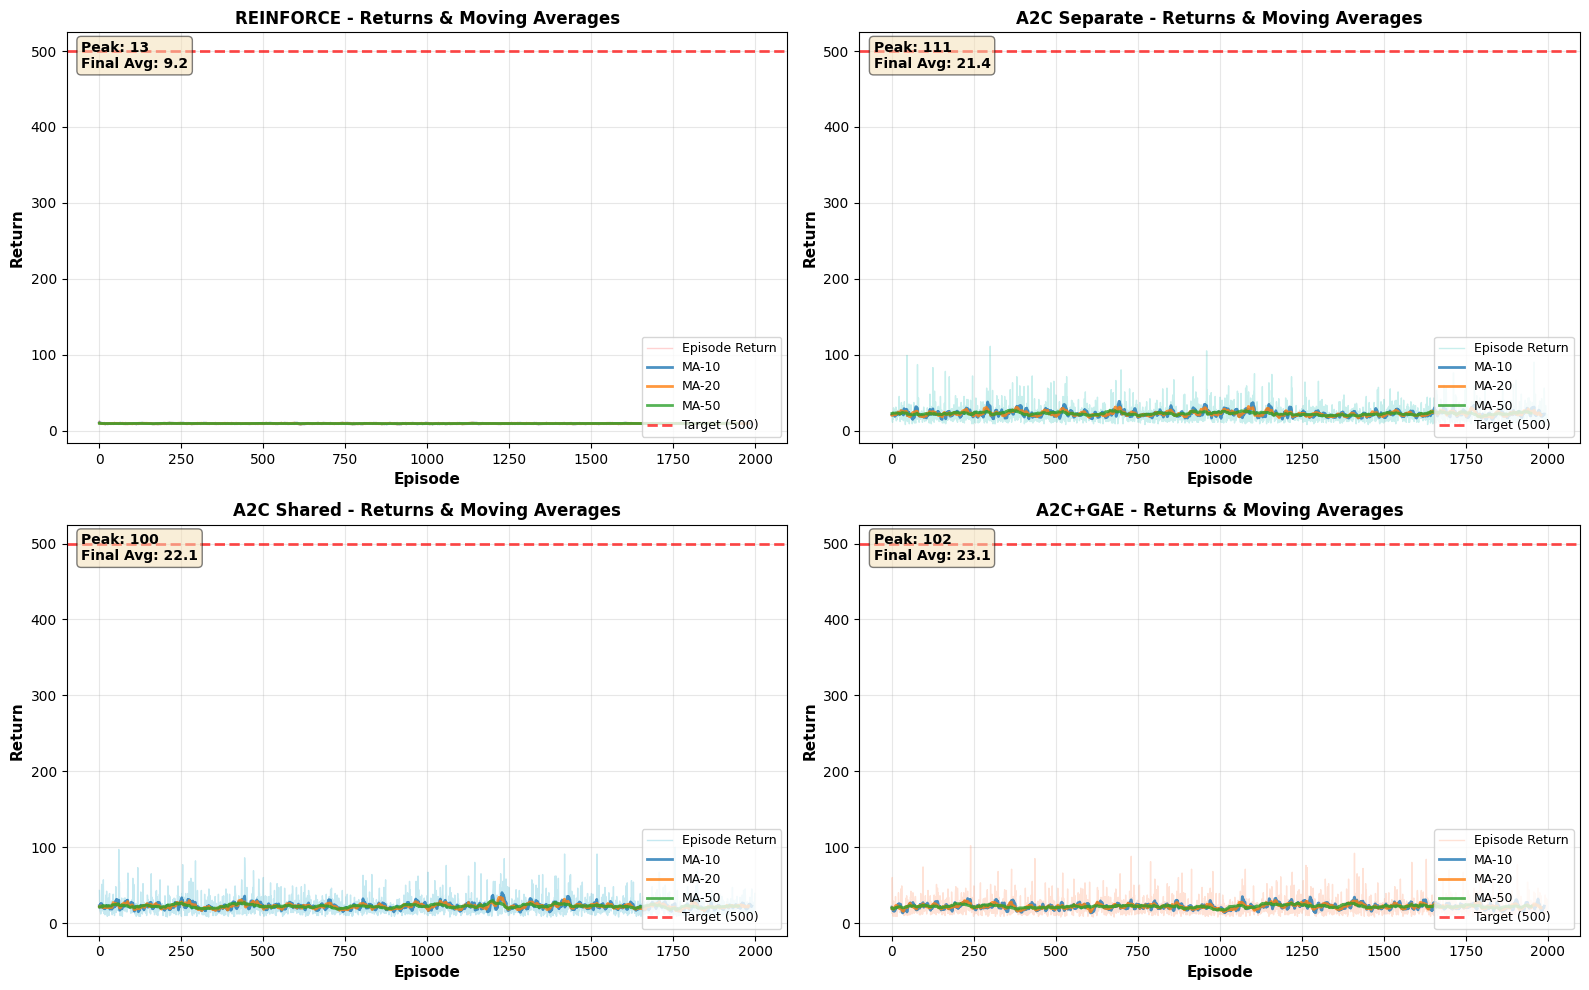


📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈
             RETURNS ANALYSIS SUMMARY
📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈

REINFORCE:
  • Overall Mean: 9.37 ± 0.73
  • Peak Return: 13
  • Final 30-Ep Average: 9.23

A2C Separate:
  • Overall Mean: 22.45 ± 12.00
  • Peak Return: 111
  • Final 30-Ep Average: 21.40

A2C Shared:
  • Overall Mean: 22.35 ± 11.88
  • Peak Return: 100
  • Final 30-Ep Average: 22.10

A2C+GAE:
  • Overall Mean: 22.05 ± 11.71
  • Peak Return: 102
  • Final 30-Ep Average: 23.07



In [19]:

# Returns and Mean Returns Visualization
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

algorithms = [
    ("REINFORCE", all_rewards, '#FF6B6B'),
    ("A2C Separate", all_rewards_a2c_sep, '#4ECDC4'),
    ("A2C Shared", all_rewards_a2c_shared, '#45B7D1'),
    ("A2C+GAE", all_rewards_gae, '#FFA07A')
]

# Plot returns and mean returns for each algorithm
for idx, (name, rewards, color) in enumerate(algorithms):
    ax = axes[idx // 2, idx % 2]
    
    rewards_array = np.array(rewards)
    episodes = np.arange(len(rewards_array))
    
    # Plot raw returns
    ax.plot(episodes, rewards_array, alpha=0.3, label='Episode Return', color=color, linewidth=1)
    
    # Plot moving averages
    for window in [10, 20, 50]:
        if len(rewards_array) > window:
            ma = np.convolve(rewards_array, np.ones(window)/window, mode='valid')
            ax.plot(np.arange(len(ma)), ma, label=f'MA-{window}', linewidth=2, alpha=0.8)
    
    # Add threshold line at 500
    ax.axhline(y=500, color='red', linestyle='--', linewidth=2, label='Target (500)', alpha=0.7)
    
    ax.set_xlabel("Episode", fontsize=11, fontweight='bold')
    ax.set_ylabel("Return", fontsize=11, fontweight='bold')
    ax.set_title(f"{name} - Returns & Moving Averages", fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)
    
    # Add statistics text
    final_avg = np.mean(rewards_array[-30:])
    peak = np.max(rewards_array)
    stats_text = f"Peak: {peak:.0f}\nFinal Avg: {final_avg:.1f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontweight='bold')

plt.tight_layout()
plt.savefig("./results/cartpole_returns_analysis.png", dpi=150, bbox_inches='tight')
print("✓ Returns and Mean Returns plot saved to './results/cartpole_returns_analysis.png'")
plt.show()

# Summary statistics
print("\n" + "📈"*40)
print("             RETURNS ANALYSIS SUMMARY")
print("📈"*40 + "\n")

for name, rewards, _ in algorithms:
    rewards_array = np.array(rewards)
    final_avg = np.mean(rewards_array[-30:])
    peak = np.max(rewards_array)
    mean_all = np.mean(rewards_array)
    std_all = np.std(rewards_array)
    
    print(f"{name}:")
    print(f"  • Overall Mean: {mean_all:.2f} ± {std_all:.2f}")
    print(f"  • Peak Return: {peak:.0f}")
    print(f"  • Final 30-Ep Average: {final_avg:.2f}")
    print()


## 🎓 Cell 14: Returns and Mean Returns Analysis
Display comprehensive comparison metrics with convergence rates, success rates, and best-performing algorithms